### Attrition Model Building using Boosting ###
This is the sequel to the Decision Tree Model Building for predicting employee churn. Given that a single decision tree is prone to overfitting and can cause high variance depending on the test train split, it is a logical step to extend the model using Boosting to sequentially build trees that correct errors from previous trees, resulting in a powerful ensemble model that can achieve high accuracy while controlling overfitting through regularization.

This exercise explores the utilisation of XGBoost Classifier, AdaBoost Classifer to build models and evaluate their performance.

What is missing however, is the infra and computational cost aspect of the models. Given that the sample dataset is small, performance is NOT expected to be different enough to be noticeable.

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import time


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("Why are employees leaving.csv")  #Loading file into my Notebook
df.head()

,ID,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Division,salary
0,1,0.38,0.53,2,157,3,0,1,0,sales,low
1,2,0.80,0.86,5,262,6,0,1,0,sales,medium
2,3,0.11,0.88,7,272,4,0,1,0,sales,medium
3,4,0.72,0.87,5,223,5,0,1,0,sales,low
4,5,0.37,0.52,2,159,3,0,1,0,sales,low


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     14999 non-null  int64  
 1   satisfaction_level     14999 non-null  float64
 2   last_evaluation        14999 non-null  float64
 3   number_project         14999 non-null  int64  
 4   average_montly_hours   14999 non-null  int64  
 5   time_spend_company     14999 non-null  int64  
 6   Work_accident          14999 non-null  int64  
 7   left                   14999 non-null  int64  
 8   promotion_last_5years  14999 non-null  int64  
 9   Division               14999 non-null  object 
 10  salary                 14999 non-null  object 
dtypes: float64(2), int64(7), object(2)
memory usage: 1.3+ MB


In [3]:
df_encoded = df.copy()

division_encoder = LabelEncoder()
salary_encoder = LabelEncoder()
df_encoded['Division'] = division_encoder.fit_transform(df_encoded['Division'])
df_encoded['salary'] = salary_encoder.fit_transform(df_encoded['salary'])
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     14999 non-null  int64  
 1   satisfaction_level     14999 non-null  float64
 2   last_evaluation        14999 non-null  float64
 3   number_project         14999 non-null  int64  
 4   average_montly_hours   14999 non-null  int64  
 5   time_spend_company     14999 non-null  int64  
 6   Work_accident          14999 non-null  int64  
 7   left                   14999 non-null  int64  
 8   promotion_last_5years  14999 non-null  int64  
 9   Division               14999 non-null  int64  
 10  salary                 14999 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 1.3 MB


In [4]:
# The Encodings are done as follows:

print (dict(zip(division_encoder.classes_, division_encoder.transform(division_encoder.classes_))))
print (dict(zip(salary_encoder.classes_, salary_encoder.transform(salary_encoder.classes_))))

{'IT': 0, 'RandD': 1, 'accounting': 2, 'hr': 3, 'management': 4, 'marketing': 5, 'product_mng': 6, 'sales': 7, 'support': 8, 'technical': 9}
{'high': 0, 'low': 1, 'medium': 2}


In [5]:
df_encoded.isnull().sum()

ID                       0
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Division                 0
salary                   0
dtype: int64

In [6]:
X = df_encoded.drop(columns=['left', 'ID'])
y = df_encoded['left']

In [7]:
N_observations, N_features = X.shape
print('Number of Observations: ' + str(N_observations))
print('Number of Features: ' + str(N_features))

Number of Observations: 14999
Number of Features: 9


In [8]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.2, random_state=42)

#### Till the above point both approaches are the same. The dataset has been label encoded for categorical variables ####

### Initialise XGBoost Classifier ###

In [9]:
num_trees = 100
max_depth = 10
min_samples_split = 10
min_samples_leaf = 2

xgb_model = XGBClassifier(n_estimators=num_trees, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)

start_time = time.time()
xgb_model.fit(X_trainset, y_trainset)
end_time = time.time()

print(f"Time taken to train the model: {end_time - start_time} seconds for {num_trees} trees")

y_pred = xgb_model.predict(X_testset)

print(f"Accuracy: {accuracy_score(y_testset, y_pred)}")

Time taken to train the model: 0.12513399124145508 seconds for 100 trees
Accuracy: 0.9873333333333333


### Now lets test the effect of the number of trees and depth of each tree on the Accuracy and Time Taken ##

In [10]:
# Function to evaluate model performance for different numbers of trees
def evaluate_num_trees(max_depth):
    n_trees_range = range(10, 110, 10)
    accuracies = []
    training_times = []
    
    for n_trees in n_trees_range:
        # Initialize and train model
        xgb_model = XGBClassifier(n_estimators=n_trees, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)

        # Time the training
        start = time.time()
        xgb_model.fit(X_trainset, y_trainset)
        end = time.time()
        
        # Make predictions and get accuracy
        y_pred = xgb_model.predict(X_testset)
        acc = accuracy_score(y_testset, y_pred)
        
        training_times.append(end - start)
        accuracies.append(acc)
    
    return list(n_trees_range), accuracies, training_times


Evaluating max_depth = 3
Evaluating max_depth = 4
Evaluating max_depth = 5
Evaluating max_depth = 6
Evaluating max_depth = 7
Evaluating max_depth = 8
Evaluating max_depth = 9
Evaluating max_depth = 10


<Figure size 1500x800 with 0 Axes>

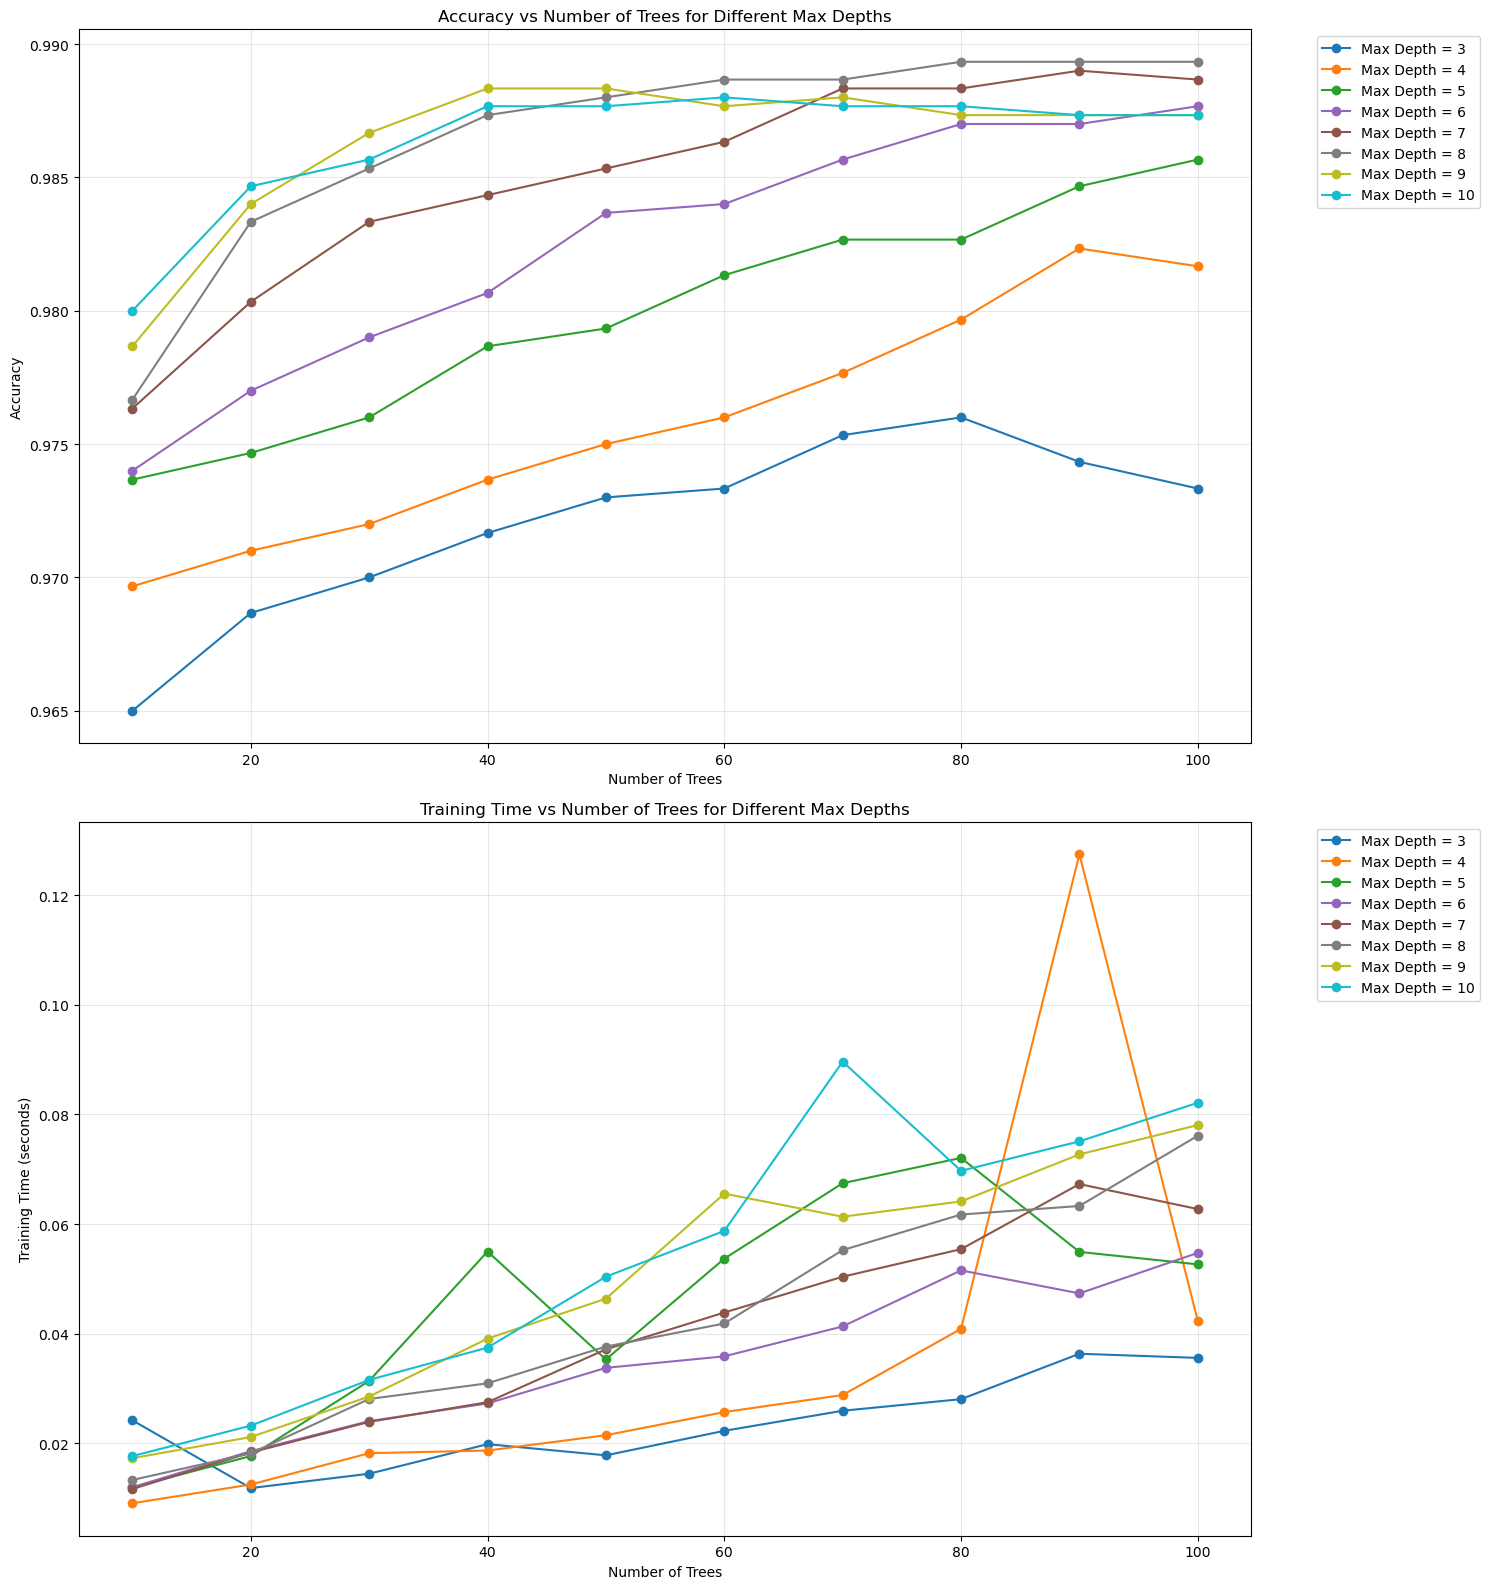

In [11]:
def evaluate_max_depths(min,max):
    plt.figure(figsize=(15, 8))
    
    # Create a color palette for different depths
    colors = plt.cm.tab10(np.linspace(0, 1, max-min+1))
    
    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 16))
    
    for i, depth in enumerate(range(min, max+1)):
        print(f"Evaluating max_depth = {depth}")
        n_trees_range, accuracies, training_times = evaluate_num_trees(depth)
        
        # Plot accuracy vs number of trees for this depth
        ax1.plot(n_trees_range, accuracies, marker='o', label=f'Max Depth = {depth}', color=colors[i])
        
        # Plot training times vs number of trees for this depth
        ax2.plot(n_trees_range, training_times, marker='o', label=f'Max Depth = {depth}', color=colors[i])
    
    # Configure accuracy subplot
    ax1.set_xlabel('Number of Trees')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy vs Number of Trees for Different Max Depths')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Configure training time subplot
    ax2.set_xlabel('Number of Trees')
    ax2.set_ylabel('Training Time (seconds)')
    ax2.set_title('Training Time vs Number of Trees for Different Max Depths')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
# Run evaluation for different max depths
evaluate_max_depths(3, 10)

Evaluating max_depth = 7
Evaluating max_depth = 8
Evaluating max_depth = 9
Evaluating max_depth = 10


<Figure size 1500x800 with 0 Axes>

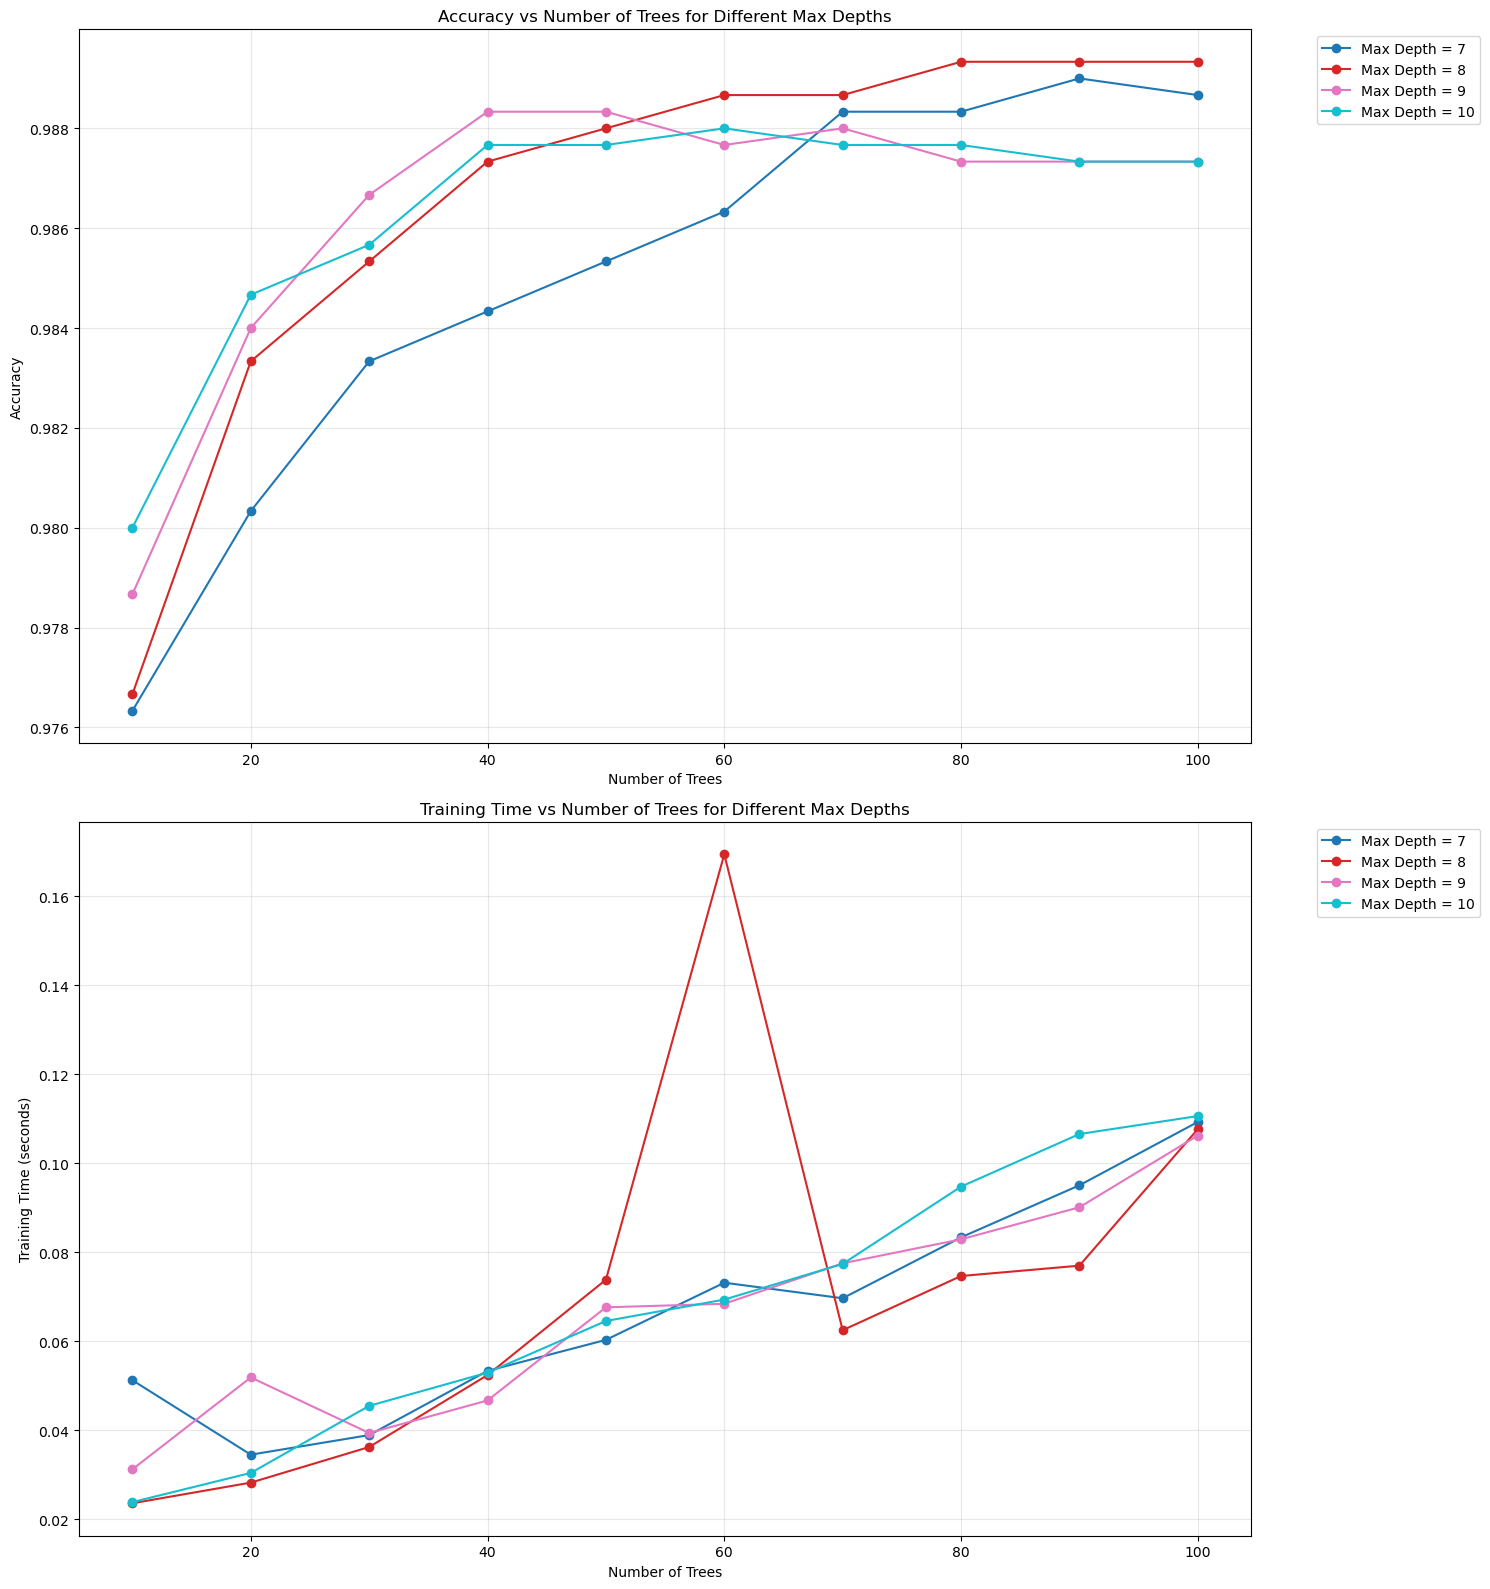

In [16]:
evaluate_max_depths(7,10)

### We see that for Depths 9 and 10, Accuracy starts to go down, indicating Overfitting ###

8 Depth seems to give the most optimal result and accuracy gains seem to drop after 40 trees. Even 10 or 20 seem to be a great choice. So lets try with a more wider range of number of trees for depth 8

In [22]:
def evaluate_num_trees(min,max):
    n_trees_range = range(min, max+1, 1)
    accuracies = []
    training_times = []
    
    for n_trees in n_trees_range:
        # Initialize and train model
        xgb_model = XGBClassifier(n_estimators=n_trees, max_depth=8, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)

        # Time the training
        start = time.time()
        xgb_model.fit(X_trainset, y_trainset)
        end = time.time()
        
        # Make predictions and get accuracy
        y_pred = xgb_model.predict(X_testset)
        acc = accuracy_score(y_testset, y_pred)
        
        training_times.append(end - start)
        accuracies.append(acc)
    
    # Plot accuracy vs number of trees
    plt.figure(figsize=(10,6))
    plt.plot(list(n_trees_range), accuracies, marker='o')
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Trees (Max Depth=8)')
    plt.grid(True, alpha=0.3)
    plt.show()

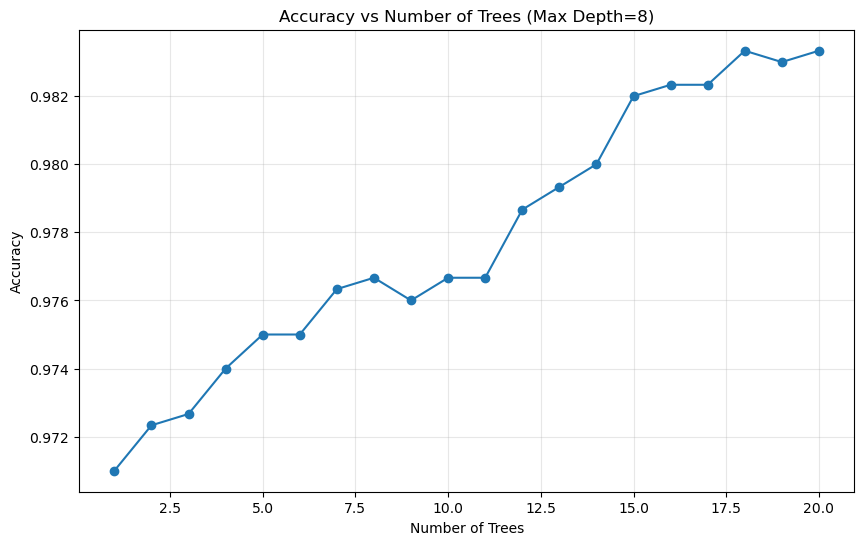

In [23]:
evaluate_num_trees(1, 20)

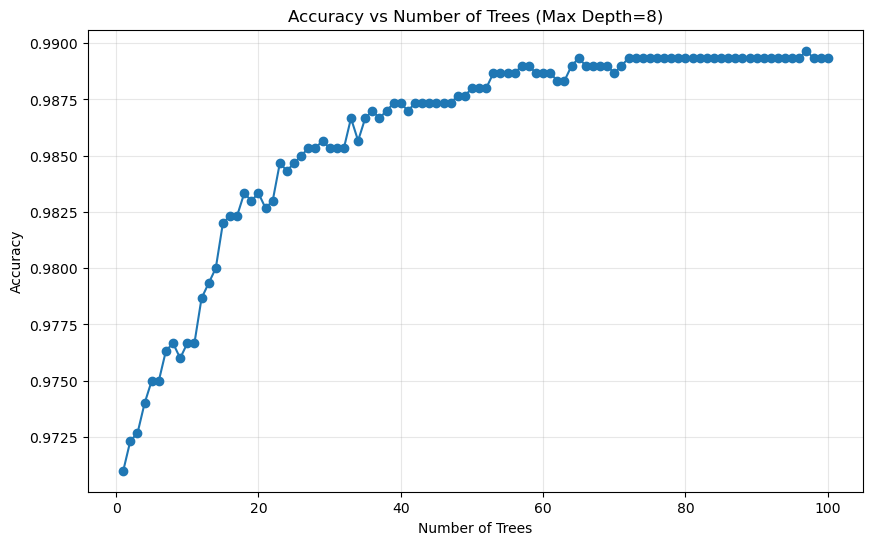

In [24]:
evaluate_num_trees(1,100)

### So we can see that the increase in accuracy definitely slows down at higher number of trees ###

We can stop at 20. Post 20 There is a marked slowdown as evident from the flattening slope.

Lets check for different initialisation states at depth 8 and 20 trees to inspect initilisation impact.

In [ ]:
def evaluate_num_trees(min,max):
    rv_range = range(min, max+1, 1)
    accuracies = []
    training_times = []
    
    for rv in rv_range:
        # Initialize and train model
        xgb_model = XGBClassifier(n_estimators=20, max_depth=8, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=rv)

        # Time the training
        start = time.time()
        xgb_model.fit(X_trainset, y_trainset)
        end = time.time()
        
        # Make predictions and get accuracy
        y_pred = xgb_model.predict(X_testset)
        acc = accuracy_score(y_testset, y_pred)
        
        training_times.append(end - start)
        accuracies.append(acc)
    
    # Plot accuracy vs number of trees
    plt.figure(figsize=(10,6))
    plt.plot(list(rv_range), accuracies, marker='o')
    plt.xlabel('Random State')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Random State (Max Depth=8)')
    plt.grid(True, alpha=0.3)
    plt.show()

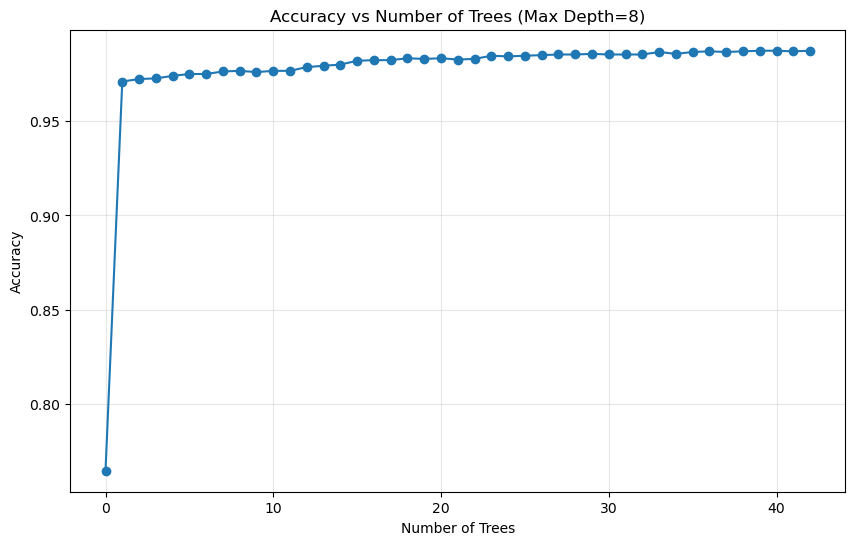

In [29]:
evaluate_num_trees(0,42)

There is a convergence in most of the random states to similar accuracies. So, we can conclude that the optimal model params for XGBoost are as follows
1. Depth 8
2. Number of trees 20

## Now Lets consider AdaBoost as an alternative to XGBoost ##
Lets initialise AdaBoost by creating a Decision Tree Classifier with depth 1 as the stump and using it as the base weak classifier.

For now, we will use learning rate 1, but will keep in mind the affect of this hyper parameter to be tuned later.

In [35]:
num_trees = 50
learning_rate = 1.0

base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)

ada_model = AdaBoostClassifier(estimator=base_estimator, n_estimators=num_trees, learning_rate=learning_rate, random_state=42)

ada_model.fit(X_trainset, y_trainset)

y_pred = ada_model.predict(X_testset)

acc = accuracy_score(y_testset, y_pred)

print(f"Accuracy: {acc}")

Accuracy: 0.929


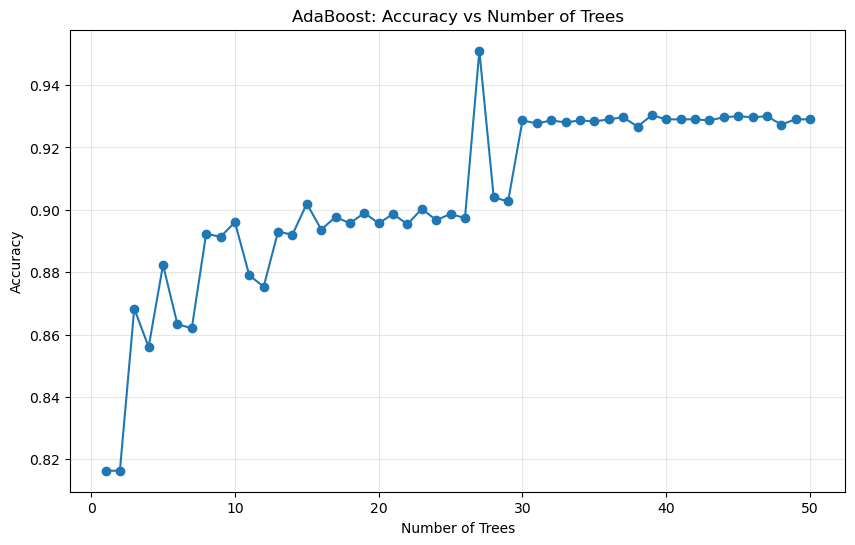

In [38]:
def evaluate_ada_num_trees(min_trees=1, max_trees=50, step=1):
    """
    Evaluate AdaBoost model performance for different numbers of trees
    """
    n_trees_range = range(min_trees, max_trees+1, step)
    accuracies = []
    
    base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)
    
    for n_trees in n_trees_range:
        # Create and train model
        model = AdaBoostClassifier(
            estimator=base_estimator,
            n_estimators=n_trees,
            learning_rate=1.0,
            random_state=42
        )
        model.fit(X_trainset, y_trainset)
        
        # Make predictions and get accuracy
        y_pred = model.predict(X_testset)
        acc = accuracy_score(y_testset, y_pred)
        accuracies.append(acc)
        
    # Plot accuracy vs number of trees
    plt.figure(figsize=(10,6))
    plt.plot(list(n_trees_range), accuracies, marker='o')
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy')
    plt.title('AdaBoost: Accuracy vs Number of Trees')
    plt.grid(True, alpha=0.3)
    plt.show()
# Test the function
evaluate_ada_num_trees(1, 50, 1)


We can see that the accuracy is not as good as XGBoost. Lets try to tune the learning rate and number of trees.

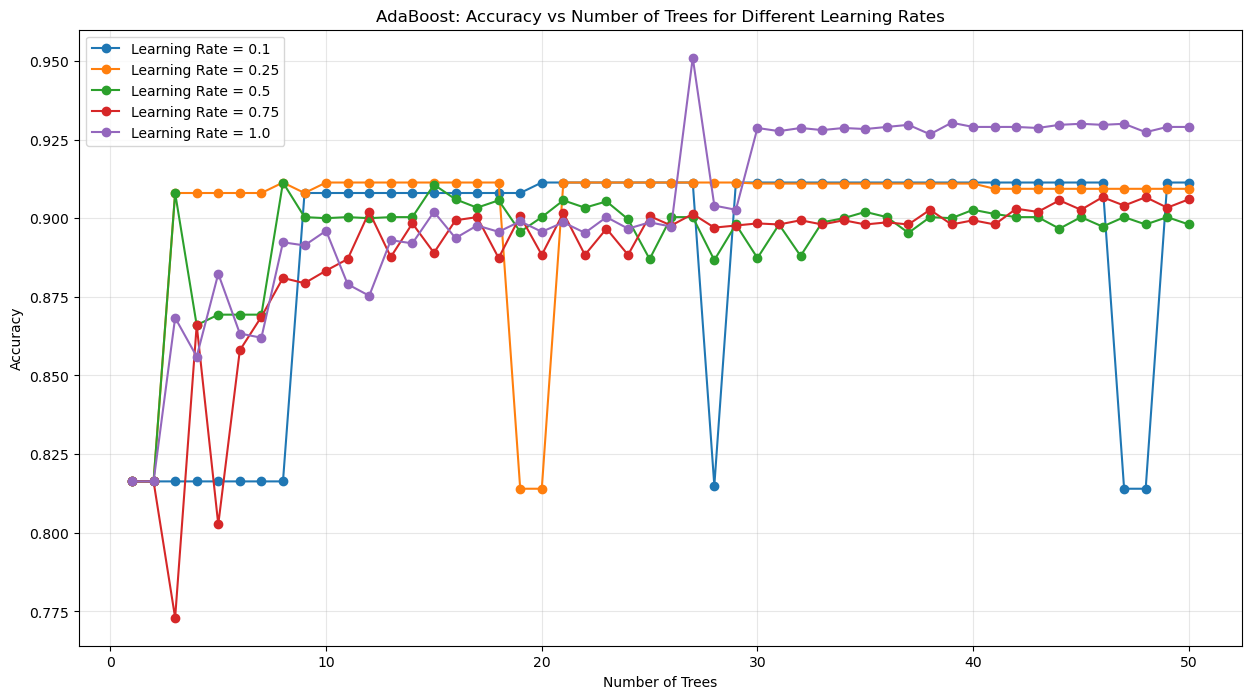

In [39]:
def evaluate_ada_learning_rates(learning_rates=[0.1, 0.25, 0.5, 0.75, 1.0]):
    """
    Evaluate AdaBoost model performance for different learning rates
    Calls evaluate_ada_num_trees() for each learning rate
    """
    plt.figure(figsize=(15, 8))
    
    for lr in learning_rates:
        n_trees_range = range(1, 51, 1)
        accuracies = []
        
        base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)
        
        for n_trees in n_trees_range:
            # Create and train model
            model = AdaBoostClassifier(
                estimator=base_estimator,
                n_estimators=n_trees,
                learning_rate=lr,
                random_state=42
            )
            model.fit(X_trainset, y_trainset)
            
            # Make predictions and get accuracy
            y_pred = model.predict(X_testset)
            acc = accuracy_score(y_testset, y_pred)
            accuracies.append(acc)
            
        # Plot accuracy vs number of trees for this learning rate
        plt.plot(list(n_trees_range), accuracies, marker='o', label=f'Learning Rate = {lr}')
    
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy')
    plt.title('AdaBoost: Accuracy vs Number of Trees for Different Learning Rates')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# Test the function with different learning rates
evaluate_ada_learning_rates([0.1, 0.25, 0.5, 0.75, 1.0])


### It can be noticed that for different learning rates, the accuracy seems to be stabilising at around 90% which is still markedly inferior to XGBoost, which does have the added benefit of not having to tune learning rate at all ###